# Set Up

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets seqeval

In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 0s (414 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120921 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.2_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.2) ...
Setting up poppler-utils (22.02.0-2ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import os

# Receipt data preparation

In [ ]:
annotation_path = Path('/content/drive/MyDrive/receipt_dataset/annotation_results.json')

with open(annotation_path, 'r') as annotation_f:
  annotation_list = json.load(annotation_f)

type(annotation_list)

list

In [ ]:
example_ = annotation_list[0]

for key in example_:
  print(key)

id
annotations
file_upload
drafts
predictions
data
meta
created_at
updated_at
inner_id
total_annotations
cancelled_annotations
total_predictions
comment_count
unresolved_comment_count
last_comment_updated_at
project
updated_by
comment_authors


In [ ]:
labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']
print(labels)

['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']


In [ ]:
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-COMPANY': 1,
 'I-COMPANY': 2,
 'B-DATE': 3,
 'I-DATE': 4,
 'B-ADDRESS': 5,
 'I-ADDRESS': 6,
 'B-TOTAL': 7,
 'I-TOTAL': 8}

In [ ]:
# converts ls normalized boxes to pixels, returns coord. for top-left and bottom-right

def unnormalize_box(result):
  value = result['value']
  w, h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = w * value['x'] / 100.0, h * value['y'] / 100.0
    x1, y1 = x0 + w * value['width'] / 100.0, y0 + h * value['height'] / 100.0
    return [x0, y0, x1, y1]

In [ ]:
# gets formatted data from ls json file for 1 task
# ex = {image: [...], words: [...], boxes: [...], ner_tags: [...]}

def get_some_formatted(receipt_ann, ds_path, label2id):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]
  image_np = np.array(Image.open(os.path.join(ds_path, image_name)))
  formatted_ex['image'] = np.expand_dims(image_np, axis=0)

  formatted_ex['words'] = [ann['value']['text'] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
  formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words'])).reshape((1, -1))


  formatted_ex['boxes'] = np.array([unnormalize_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32).reshape(1, -1, 4)

  formatted_ex['ner_tags'] = [label2id[ann['value']['labels'][0]] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'labels']
  formatted_ex['ner_tags'] = np.squeeze(np.array(formatted_ex['ner_tags'])).reshape((1, -1))

  return formatted_ex

In [ ]:
# checking result shapes after formatting

image_ds_path = Path('/content/drive/MyDrive/receipt_dataset/train')
example_cleared = get_some_formatted(example_, image_ds_path, label2id)

print(example_cleared['image'].shape, example_cleared['words'].shape, example_cleared['boxes'].shape, example_cleared['ner_tags'].shape)

(1, 3724, 1584, 3) (1, 111) (1, 111, 4) (1, 111)


In [ ]:
# getting dataset of all examples

dataset = []

for receipt_data in annotation_list:
  dataset.append(get_some_formatted(receipt_data, ds_path=image_ds_path, label2id=label2id))

print(len(dataset))

43


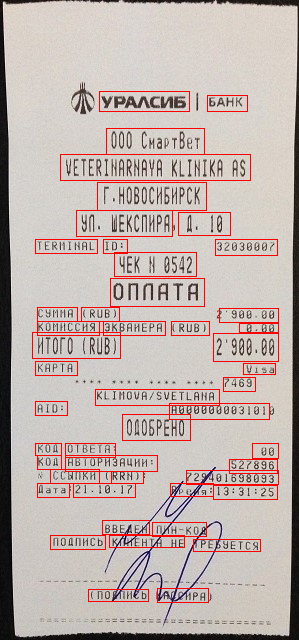

In [ ]:
example = dataset[6]
image = Image.fromarray(example['image'][0])
image_draw = ImageDraw.Draw(image)

for box in example['boxes'][0]:
  image_draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')

image

# Applying processor and model inference with

In [ ]:
# model accepts boxes in range 0..1000 xd

def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


In [ ]:
def normalize_boxes_of_data(data):
  hw = data['image'][0].shape
  for i, box in enumerate(data['boxes'][0]):
    norm_box = normalize_box_1000(box, hw[0], hw[1])
    data['boxes'][0][i] = norm_box

In [ ]:
for data in dataset:
  normalize_boxes_of_data(data)

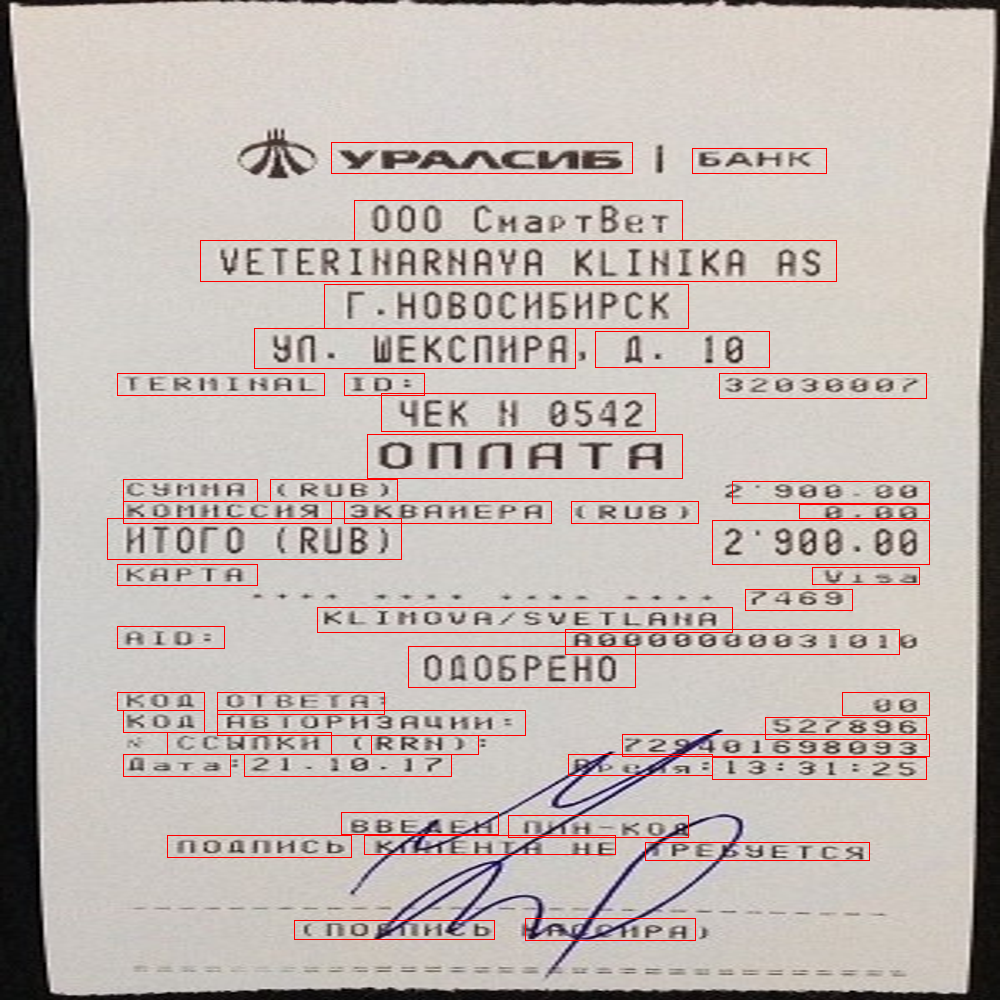

In [ ]:
# it's working

example = dataset[6]
image = Image.fromarray(example['image'][0]).resize((1000, 1000))
image_draw = ImageDraw.Draw(image)

for box in example['boxes'][0]:
  image_draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')

image

In [ ]:
example['ner_tags'][0]

array([0, 0, 1, 2, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
       0, 0, 0, 0])

In [ ]:
from transformers import AutoModelForTokenClassification, AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutmv3_checkpoint")

In [ ]:
encoded_ex_inputs = processor(example['image'][0], example['words'][0].tolist(), boxes=example['boxes'][0].tolist(),
                              word_labels=example['ner_tags'][0].tolist(), return_tensors="pt")

for k,v in encoded_ex_inputs.items():
  print(k,v.shape)

input_ids torch.Size([1, 428])
attention_mask torch.Size([1, 428])
bbox torch.Size([1, 428, 4])
labels torch.Size([1, 428])
pixel_values torch.Size([1, 3, 224, 224])


In [ ]:
processor.tokenizer.decode(encoded_ex_inputs["input_ids"][0])

'<s> УРАЛСИБ БАНК ООО СмартВет  VETERINARNAYA KLINIKA AS Г Новосибирск Ул. Шекспира Terminal 10 ; 32036997 ЧЕК N0512 ОПЛАТА СУММА (RUB) 2 900.00 КОМИССИЯ ЭКВАЙЕРА (RUB) ИТОГО (RUB) 2900,00 КАРТА 7469 KLIMOVE/SVETLANA AID: A989808983101 ОШОБРЕНО Код ОТВЕТА КОД АВТОРИЗАЦИИ 527896 ССЫЛКИ RRN Дата 21.10.17 13 : 31 : 25 ВВЕДЕН ПИН-КОД ПОДПИСЬ ТРЕБУЕТСЯ ПОДПИСЬ КАССИРА 00 Д. 10 visa 0,00 729401698093 Время КЛИЕНТА НЕ</s>'

In [ ]:
encoded_ex_inputs['labels']

tensor([[-100,    0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100,    0,    0, -100, -100, -100, -100, -100, -100,    1,
            1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100,    2, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100,    5,    5, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100,    6,    6, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100,    0,    0, -100,
            0, -100, -100,    0,    0, -100, -100, -100, -100, -100, -100, -100,
            0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
            0,    0, -100, -100, -100, -100, -100, -100, -100, -100,    0, -100,
         -100, -100,    0, -100, -100, -100,    0,    0, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,    0,    0,
         -100, -100, -100, -

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# labels = encoded_ex_inputs.pop('labels').squeeze().tolist()
for k,v in encoded_ex_inputs.items():
  encoded_ex_inputs[k] = v.to(device)

In [ ]:
model.to(device)

# forward
with torch.no_grad():
  outputs = model(**encoded_ex_inputs)

logits = outputs.logits
logits.shape

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 428, 9])

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# DUUUDDDE WHY THOUGH >>:|

In [ ]:
labels = encoded_ex_inputs.labels.squeeze().tolist()

# Attemps in true inference (Sroie)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("darentang/sroie")

In [ ]:
test_example = dataset['test'][0]
test_im = np.asarray(Image.open(test_example['image_path']))

In [ ]:
from transformers import AutoModelForTokenClassification, AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base")

In [ ]:
encoding = processor(test_im, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutmv3_checkpoint")

model.to(device)

# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 216, 9])


In [ ]:
def unnormalize_1000_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000)),
     ]

In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = Image.open(test_example['image_path']).size

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [ ]:
print(true_predictions)
print(true_boxes)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COMPANY', 'I-COMPANY', 'I-COMPANY', 'I-COMPANY', 'O', 'O', 'O', 'B-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'I-ADDRESS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TOTAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[0, 0, 0, 0], [103, 30, 154, 53], [167, 26, 242, 61], [252, 35, 308, 66], [141, 100, 173, 109], [181, 100, 230, 115], [238, 100, 270, 109], [89, 122, 122, 136], [129, 122, 237, 136], [243, 122, 279, 136], [287, 122, 324, 136], [130, 145, 164, 158], [170, 145, 198, 158], [204, 145, 283, 158], [111, 168, 132, 180], [138, 168, 146, 180], [153, 168, 183, 183], 

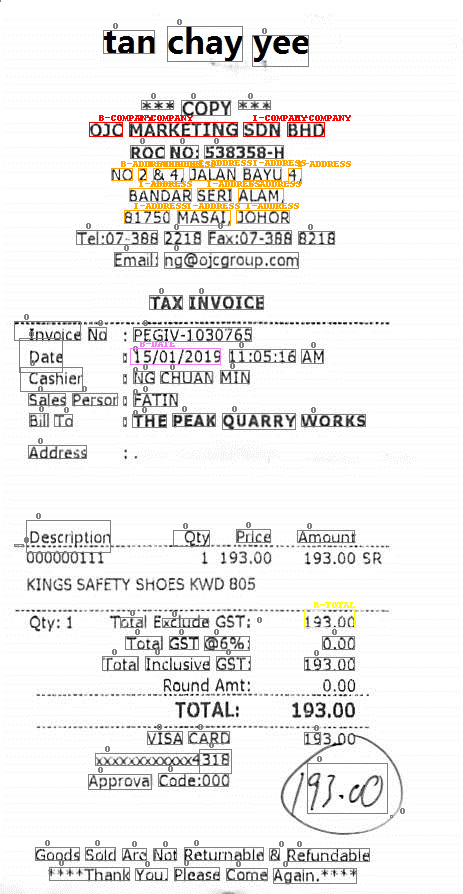

In [ ]:
test_im_pil = Image.open(test_example['image_path'])
draw = ImageDraw.Draw(test_im_pil)

def iob_to_label(label):
    if not label:
      return 'O'
    return label

label2color = {'O':'gray', 'B-COMPANY':'red', 'I-COMPANY':'red', 'B-ADDRESS': 'orange',
               'I-ADDRESS': 'orange', 'B-DATE':'violet', 'I-DATE':'violet', 'B-TOTAL':'yellow', 'I-TOTAL':'yellow'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

test_im_pil

# True inference on cyrillic receipt

In [ ]:
from pdf2image import convert_from_path

test_im = convert_from_path(Path('/content/drive/MyDrive/receipt_dataset/cool_example.pdf'))[0]

encoding = processor(test_im, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 384, 9])


In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = test_im.size

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [ ]:
print(true_predictions)
print(true_boxes)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TOTAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[0, 0, 0, 0], [444, 156, 552, 191], [575, 159, 689, 198], [421, 196, 554, 231], [575, 196, 785, 240], [807, 203, 939, 240], [965, 231, 972, 243], [1005, 201, 1037, 236], [388, 219, 555, 325], [597, 273, 611, 306], [1038, 273, 1192, 313], [420, 294, 555, 336], [1076, 311, 1190, 353], [420, 350, 651, 423], [659, 385, 721, 418], [901, 355, 1109, 392], [1132, 350, 1190, 390], [418, 406, 611, 484], [418, 465, 726,

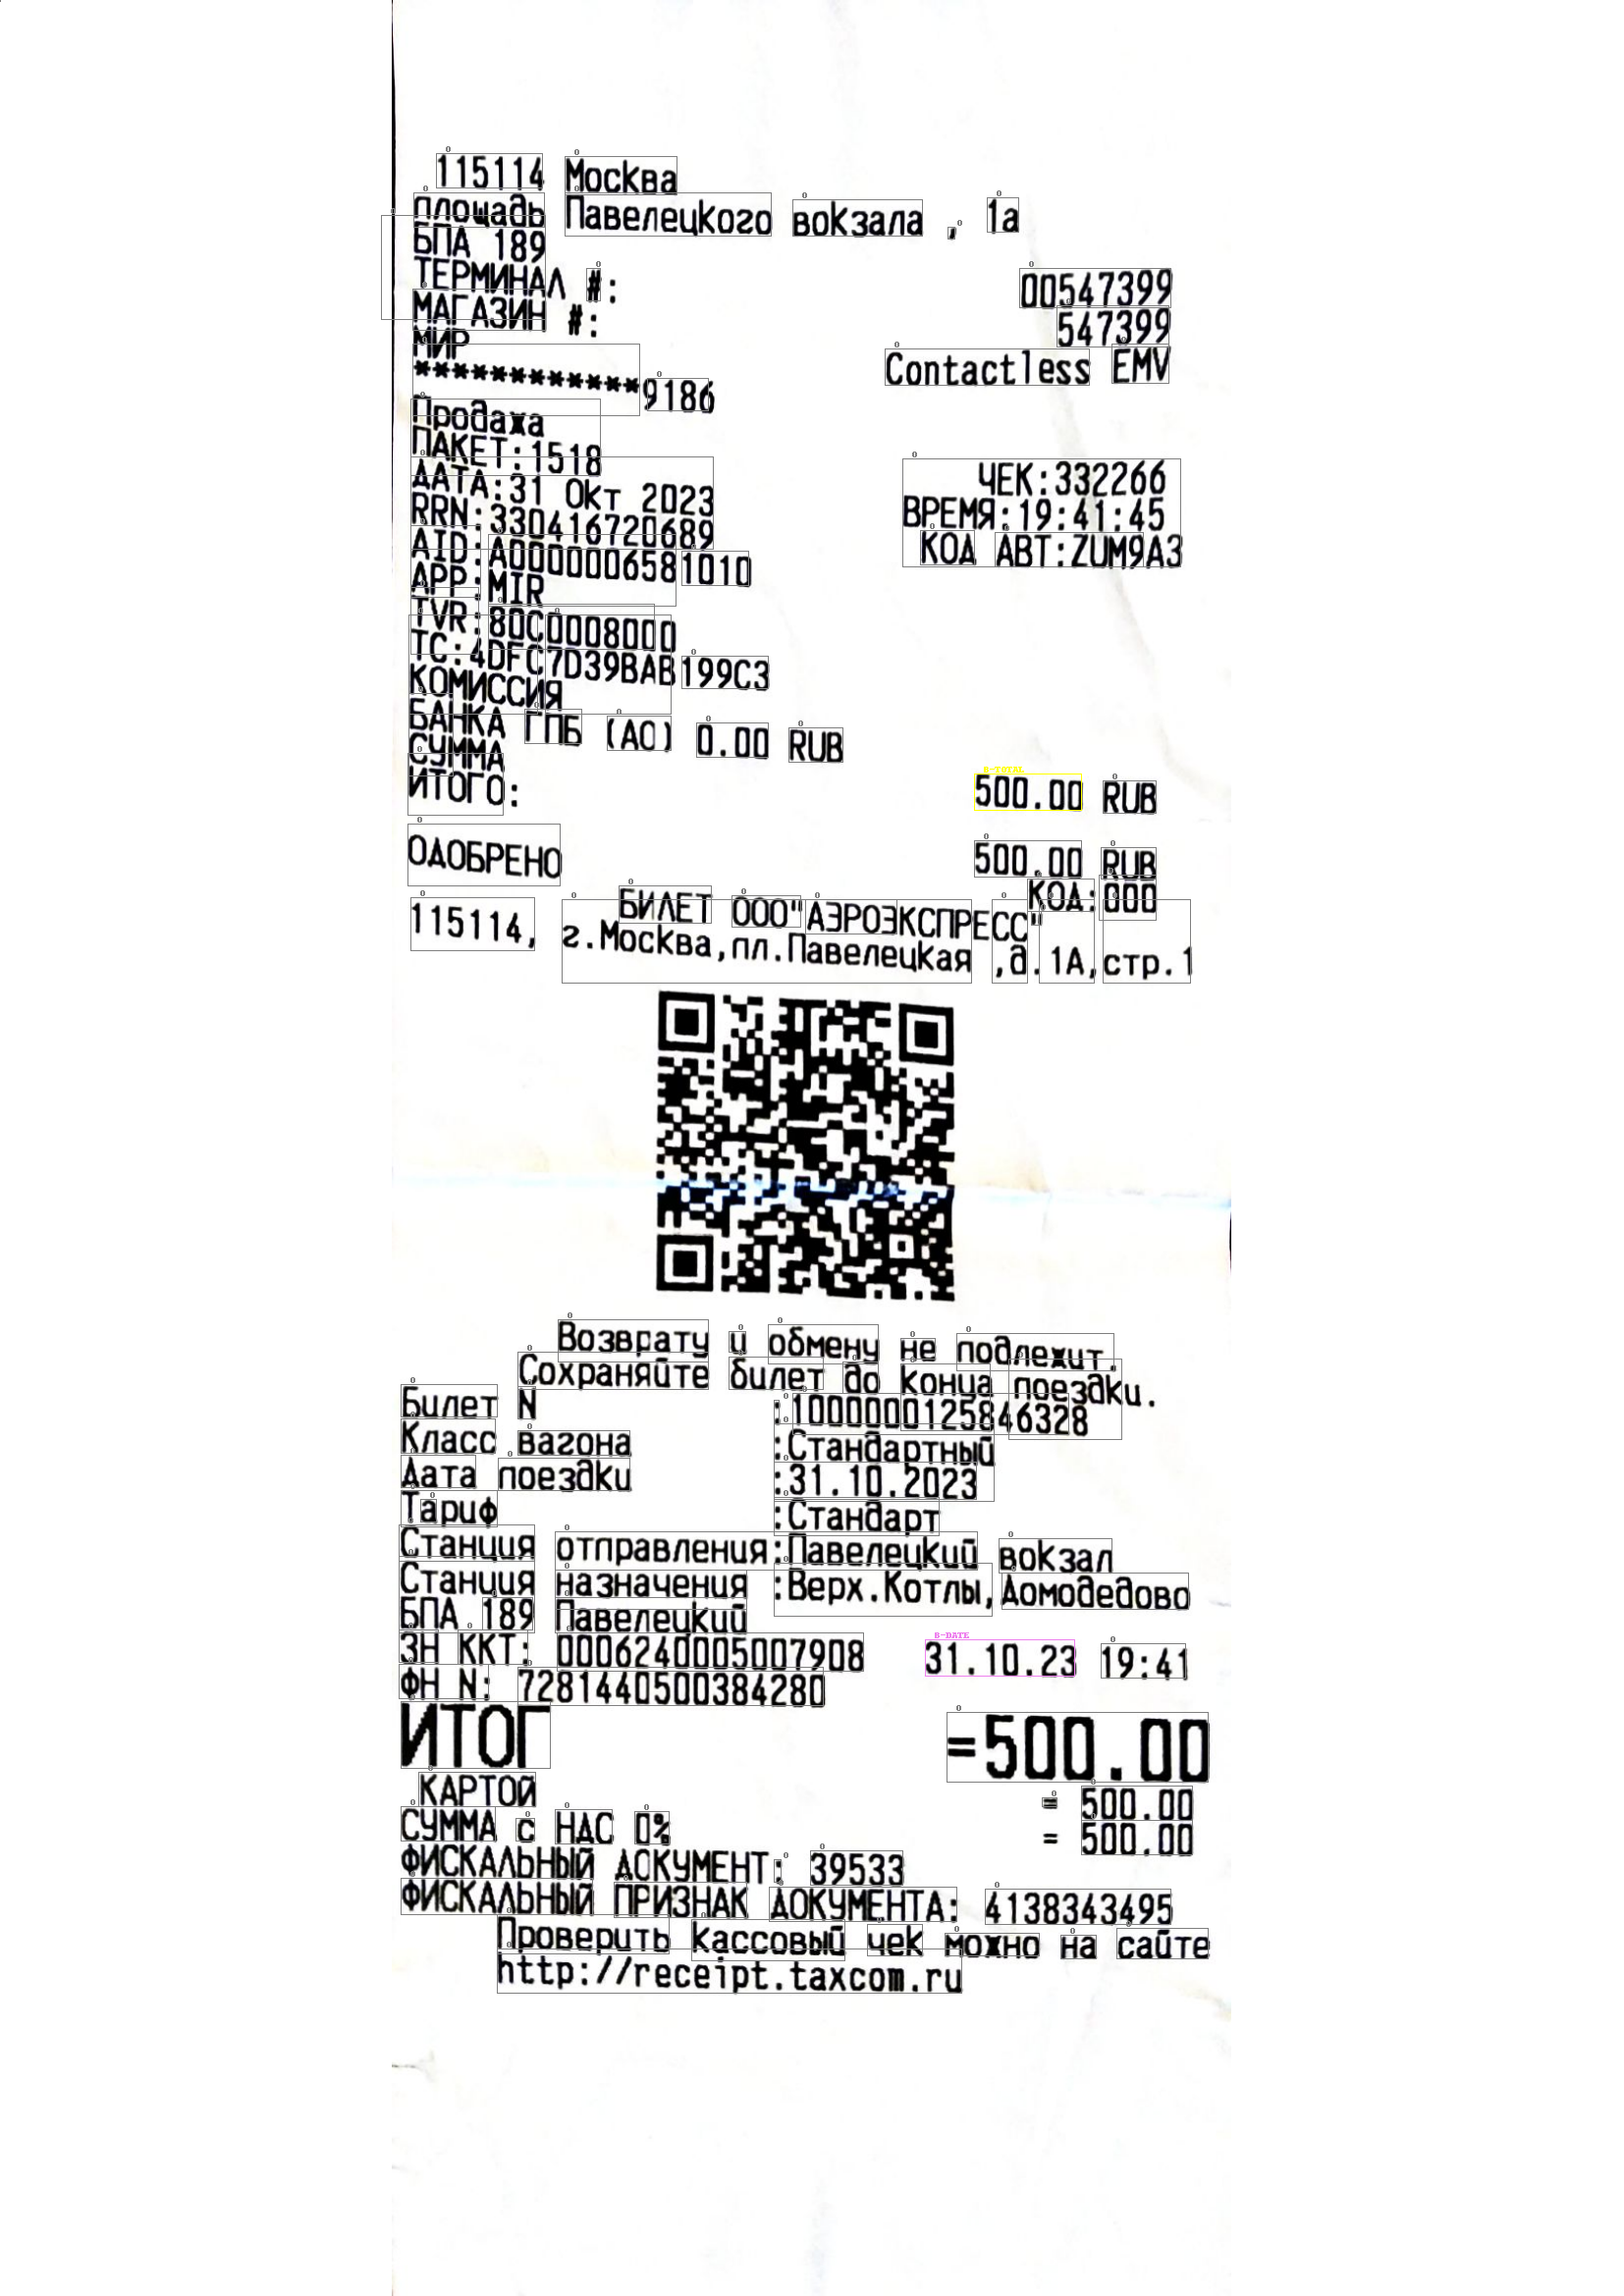

In [ ]:
draw = ImageDraw.Draw(test_im)

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

test_im